In [14]:
import pandas as pd
import BlackBoxAuditing as BBA

import pylab
%matplotlib inline

from BlackBoxAuditing.model_factories import SVM, DecisionTree, TensorFlow

Issue #1: Indication that Random & Constant Feature are predictive w/ all Models using Synthetic Data

In [ ]:
import numpy as np
import random
import pandas as pd
from BlackBoxAuditing.data import load_from_file


np.random.seed(42)  # Set a random seed for reproducibility

# Generate the features
n_samples = 6000
n_features = 5

# Features directly encoding row number i
A = np.arange(n_samples)
B = 2 * A
C = -A

# Random feature and constant feature
Random = np.random.randn(n_samples)
Constant = np.ones(n_samples) + np.random.normal(0, 0.01, n_samples)  # Add small random noise

# Concatenate the features into a numpy array
features = np.column_stack((A, B, C, Random, Constant))

# Generate the labels
labels = np.array([False]*(n_samples//2) + [True]*(n_samples//2))


# Replace NaN values with zeros
features[np.isnan(features)] = 0.0

# Create a dictionary with column names and data
column_names = {
    "A": A,
    "B": B,
    "C": C,
    "Random": Random,
    "Constant": Constant,
    "admit": labels.astype(str)
}

# Create the DataFrame
df = pd.DataFrame(column_names)

# Save the DataFrame to a CSV file
df.to_csv("/tmp/test.csv", index=False)

# Load the synthetic data using BlackBoxAuditing
synthetic_data = load_from_file(
    "/tmp/test.csv",
    correct_types=[int, int, int, float, float, str],
    response_header='admit'
)


In [ ]:
auditor = BBA.Auditor()
auditor.ModelFactory = SVM
auditor(synthetic_data, output_dir="Test")

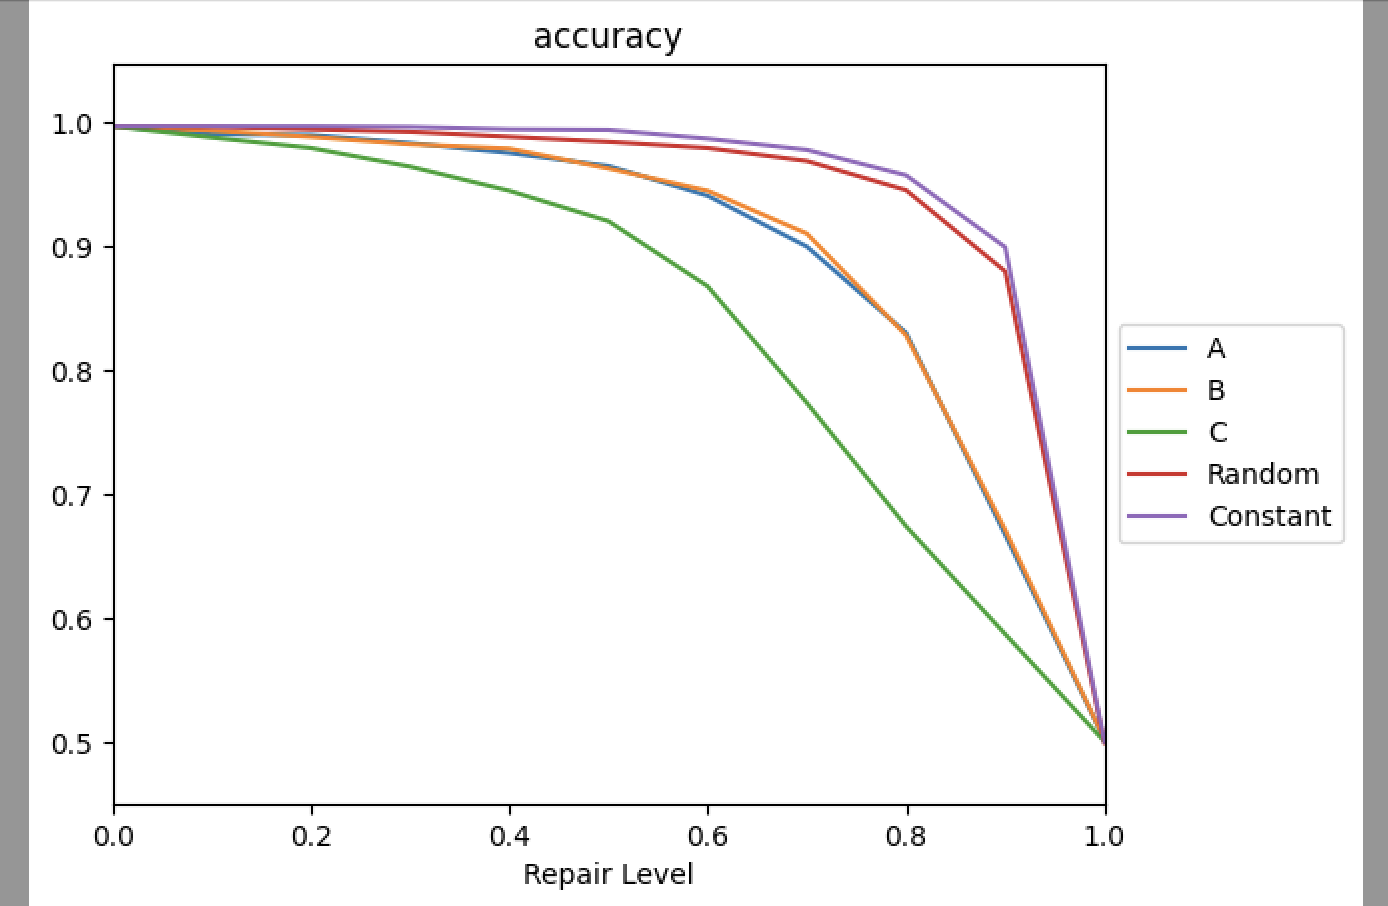

In [6]:
from IPython import display
display.Image("/Users/roccotrinci/Desktop/Syn-Data-SVM-Acc.png")

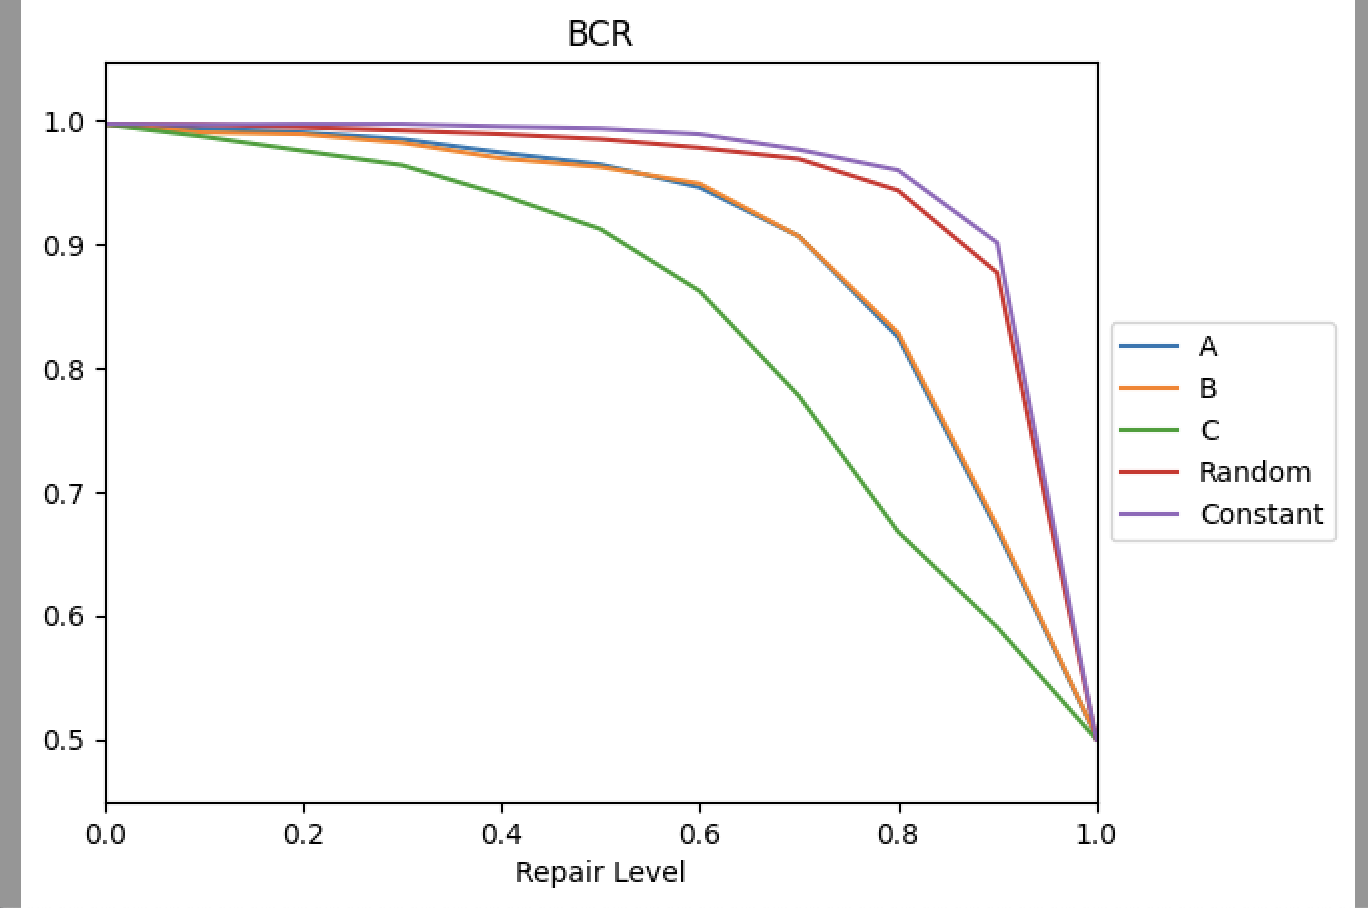

In [11]:
from IPython import display
display.Image("/Users/roccotrinci/Desktop/Syn-Data-SVM-BCR.png")

In [ ]:
auditor = BBA.Auditor()
auditor.ModelFactory = DecisionTree
auditor(synthetic_data, output_dir="Test")

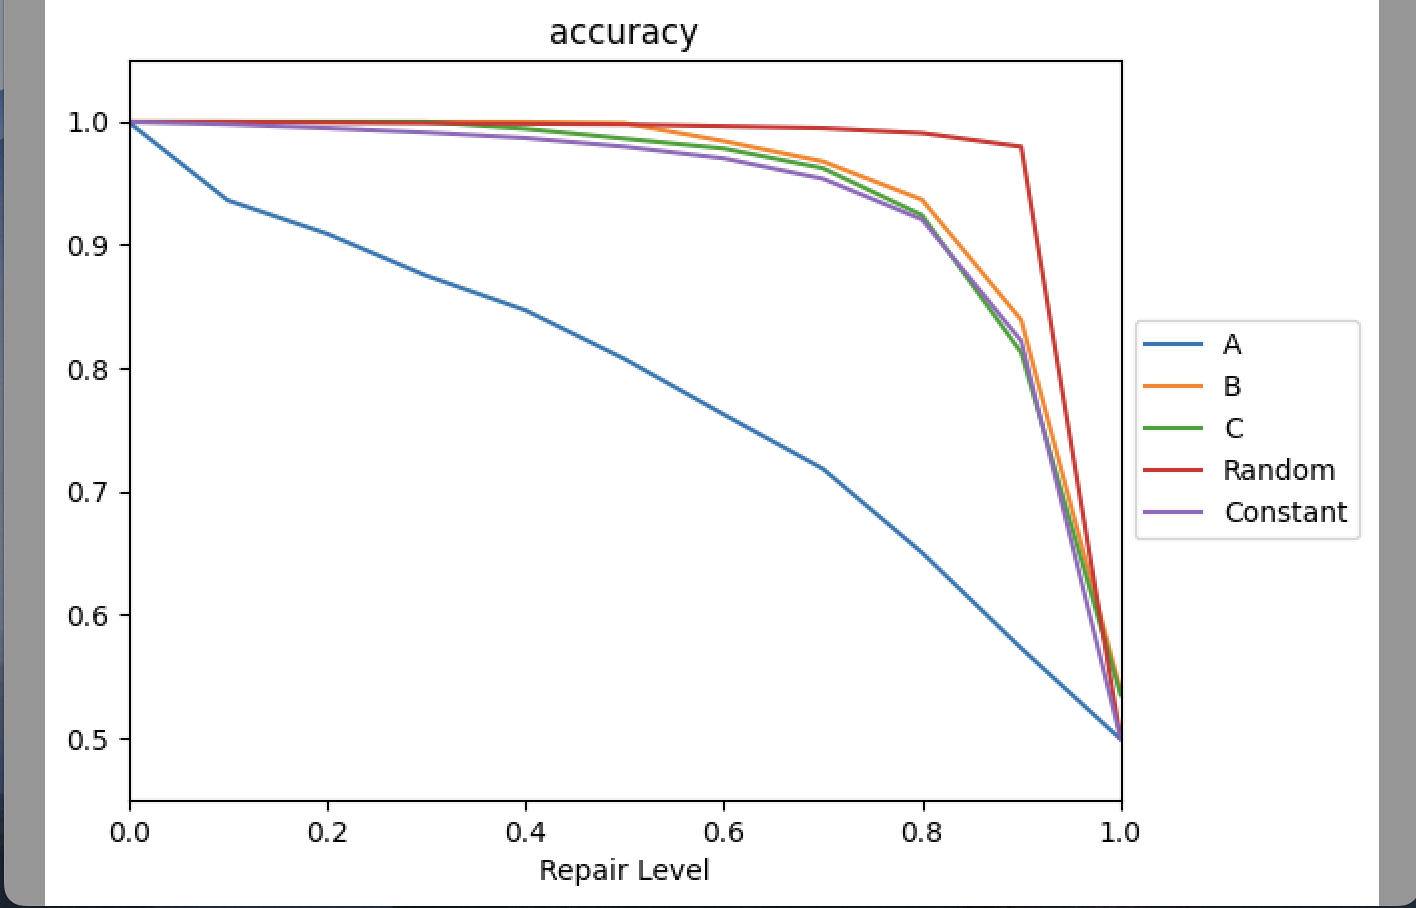

In [10]:
from IPython import display
display.Image("/Users/roccotrinci/Desktop/Syn-Data-DT-Acc.png")

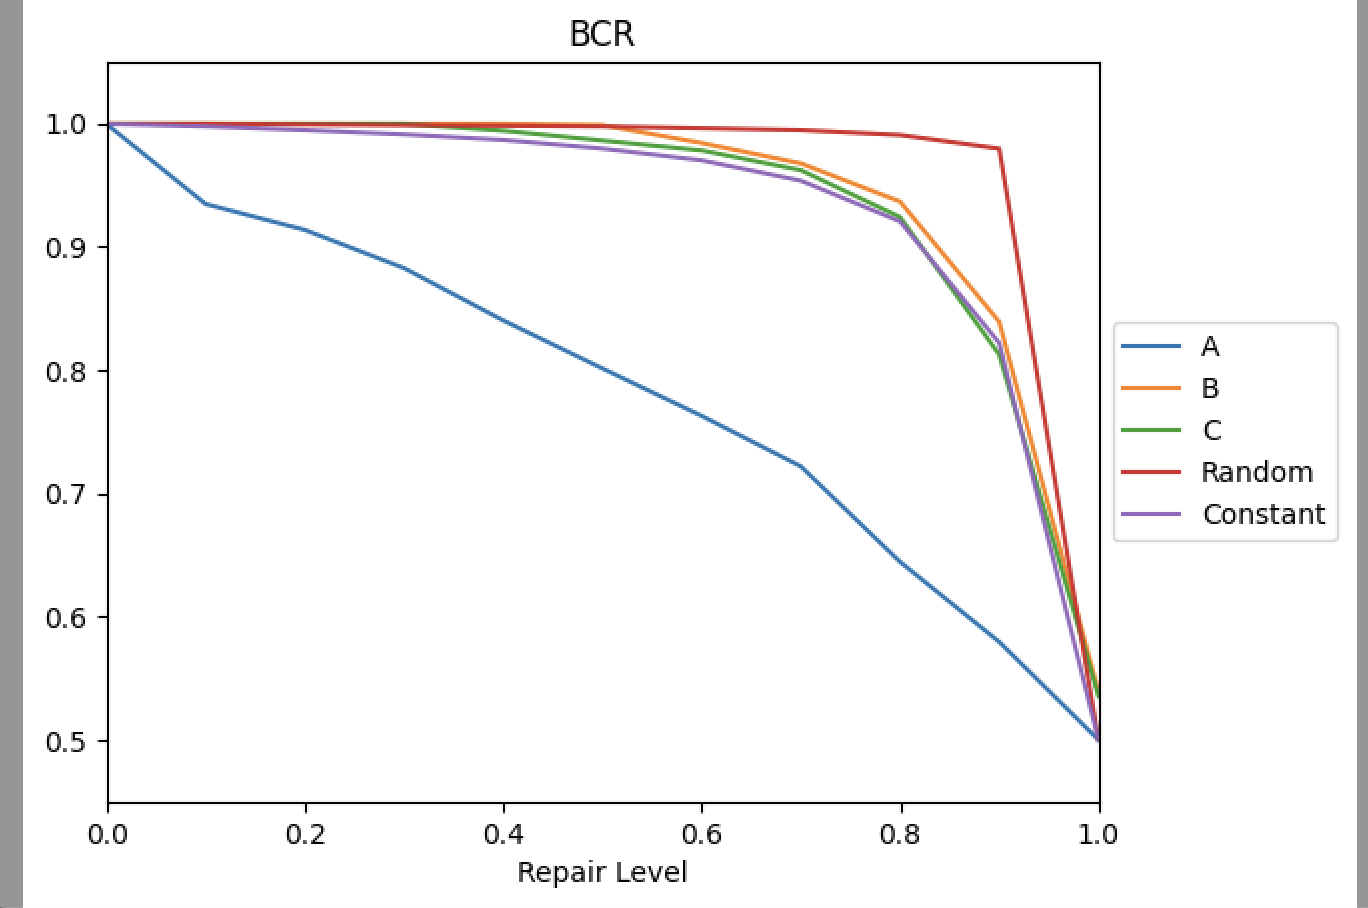

In [9]:
from IPython import display
display.Image("/Users/roccotrinci/Desktop/Syn-Data-DT-BCR.png")

In [ ]:
auditor = BBA.Auditor()
auditor.ModelFactory = TensorFlow
auditor(synthetic_data, output_dir="Test")

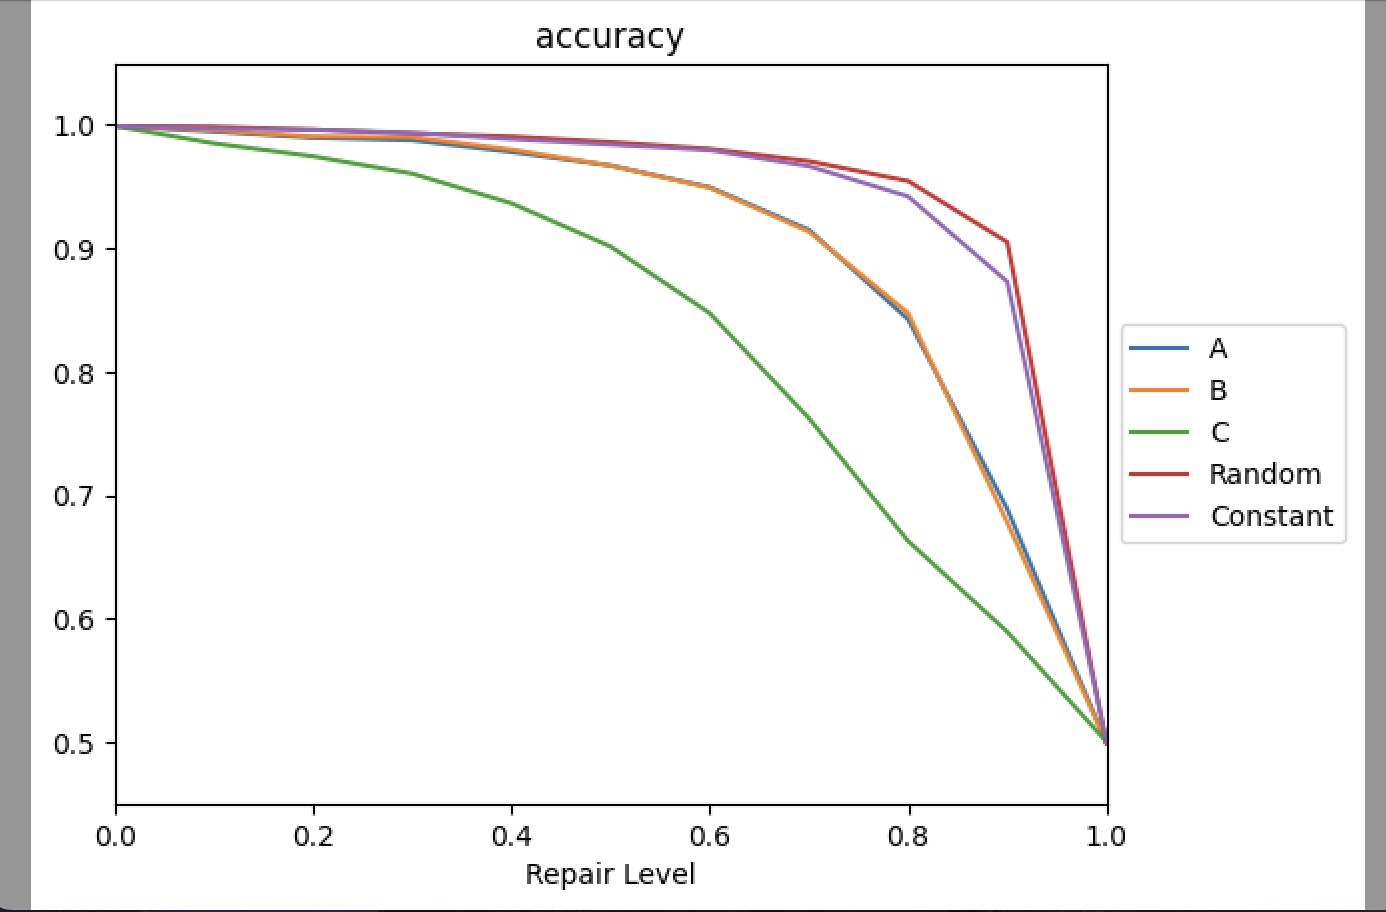

In [7]:
from IPython import display
display.Image("/Users/roccotrinci/Desktop/Syn-Data-NN-Acc.png")

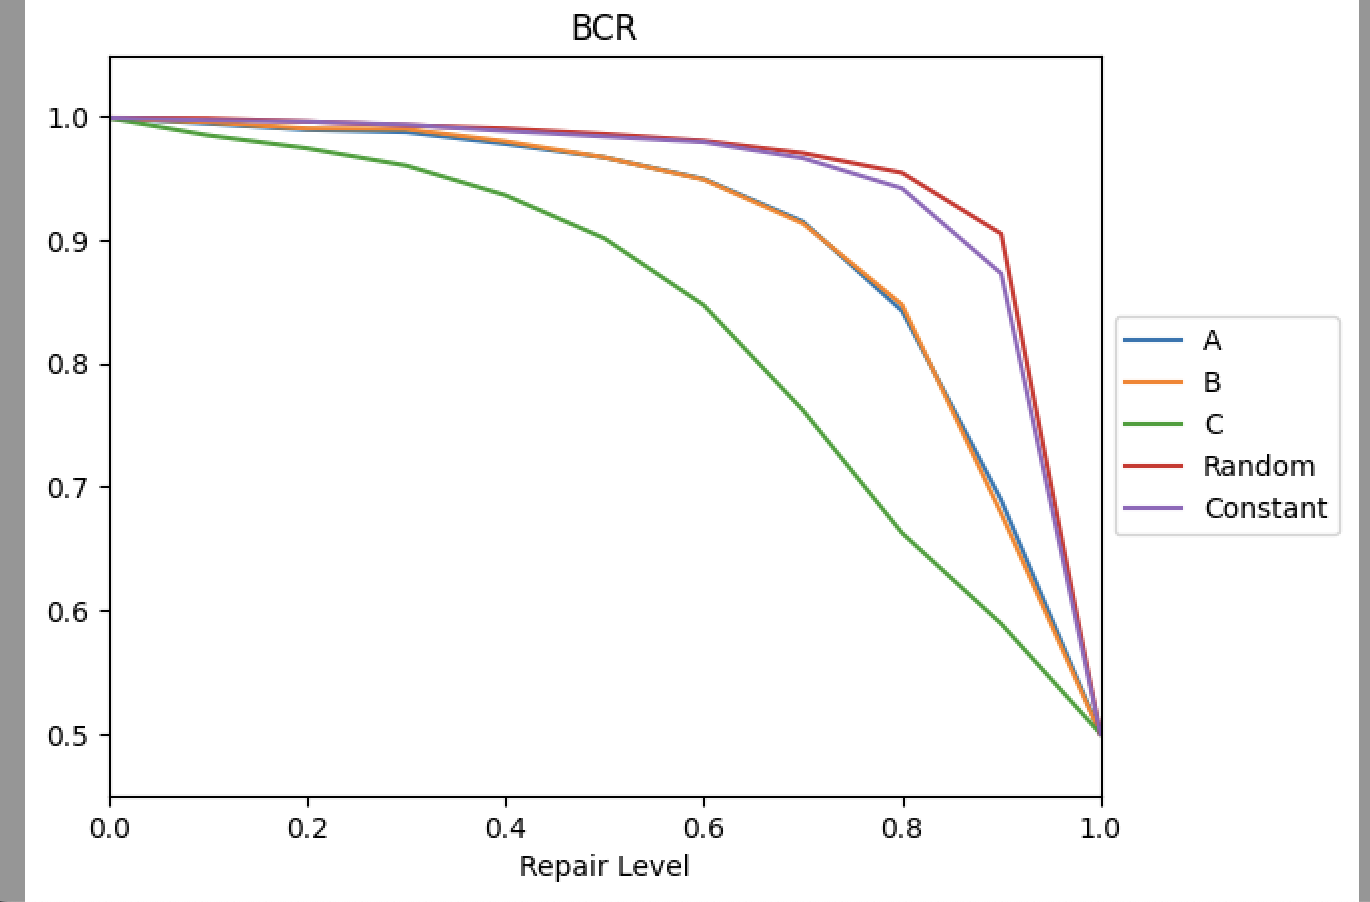

In [8]:
from IPython import display
display.Image("/Users/roccotrinci/Desktop/Syn-Data-NN-BCR.png")

Issue #2: Decision Tree does not run correctly with certain datasets

In [15]:
german_data = BBA.load_data("german")
ricci_data = BBA.load_data("ricci")
adult_data = BBA.load_data("adult")

In [17]:
auditor = BBA.Auditor()
auditor.ModelFactory = DecisionTree
auditor(adult_data, output_dir="DT-Test")

Training initial model. (13:48:42)
Calculating original model statistics on test data:
	Training Set:


ValueError: 1 is not in list

Issues is due to fact that in 'predictions' tuple, there are cases where element [0,0] appears instead either [0,1] or [1,0], indicating that model is predicting that certain observations belong to neither class, which should not occur obviously. 

A similar issue occured with the NeuralNetwork model implemented. However, in tandem with my supervisor, we were able to make modifications to the NeuralNetwork.py source file on our end that would resolve this issue. Namely, we replaced the code:


    predictions = self.clf.predict(test_matrix)
    predictions, test_labels = predictions.tolist(), test_labels.tolist() # cast from numpy array to python list
    test_labels = [(corr[0], corr[1]) for corr in test_labels]
    predictions = [row.index(1) for row in predictions]
    predictions_dict = {i:key for key,i in list(self.outcome_trans_dict.items())}
    predictions = [predictions_dict[pred] for pred in predictions]
    return list(zip([row[self.response_index] for row in test_set], predictions))


With the following, which in turn resolved the issue:

    predictions = np.argmax(self.clf.predict_log_proba(test_matrix),axis=1)
    #predictions = self.clf.predict(test_matrix)
    #predictions, test_labels = predictions.tolist(), test_labels.tolist() # cast from numpy array to python list
    #test_labels = [(corr[0], corr[1]) for corr in test_labels]
    #predictions = [row.index(1) for row in predictions]
    predictions_dict = {i:key for key,i in list(self.outcome_trans_dict.items())}
    predictions = [predictions_dict[pred] for pred in predictions]
    return list(zip([row[self.response_index] for row in test_set], predictions))

However, making a similar change to the DecisionTree.py file, i.e. replacing:

    predictions = self.clf.predict(test_matrix)
    predictions, test_labels = predictions.tolist(), test_labels.tolist() # cast from numpy array to python list
    test_labels = [(corr[0], corr[1]) for corr in test_labels]
    predictions = [row.index(1) for row in predictions]
    predictions_dict = {i:key for key,i in list(self.outcome_trans_dict.items())}
    predictions = [predictions_dict[pred] for pred in predictions]
    return list(zip([row[self.response_index] for row in test_set], predictions))
    
with:

    predictions = np.argmax(self.clf.predict_log_proba(test_matrix),axis=1)
    #predictions = self.clf.predict(test_matrix)
    #predictions, test_labels = predictions.tolist(), test_labels.tolist() # cast from numpy array to python list
    #test_labels = [(corr[0], corr[1]) for corr in test_labels]
    #predictions = [row.index(1) for row in predictions]
    predictions_dict = {i:key for key,i in list(self.outcome_trans_dict.items())}
    predictions = [predictions_dict[pred] for pred in predictions]
    return list(zip([row[self.response_index] for row in test_set], predictions))

resulted in a new error:



In [1]:
import pandas as pd
import BlackBoxAuditing as BBA

import pylab
%matplotlib inline